In [1]:
import os
import MeCab
import pandas as pd
import numpy as np
from os import path
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from matplotlib.pyplot import figure
from matplotlib.figure import Figure
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)
import re
from collections import Counter
import seaborn as sb
import random
from google.cloud import storage as gcs
import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
from gensim.models import LsiModel
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

In [2]:
INPUT_BUCKET = 'gs://mj-labeling-questionnaires-dev.datasets.linkbal.com/inputs/ver_01/'
PROJECT_NAME = 'linkbal-dp'
BUCKET_NAME = 'mj-labeling-questionnaires-dev.datasets.linkbal.com' 
client = gcs.Client(PROJECT_NAME)
bucket = gcs.Bucket(client, name=BUCKET_NAME)
jp_stop_words = open("/Users/jesse.ulundo/demo_tests/Japanese_stopword_list.txt", "r")


//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning:

Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/



In [3]:
tagger = MeCab.Tagger()

In [4]:
qs = pd.read_csv(INPUT_BUCKET + 'mj_questionnaire_text.csv', sep=',')

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning:

Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/



In [5]:
qs

,id,overall_satisfaction,overall_satisfaction_reason,want_recommend,want_recommend_reason
0,111372,2.0,NaN,0.0,NaN
1,111373,1.0,NaN,0.0,NaN
2,111374,3.0,NaN,2.0,NaN
3,111375,3.0,NaN,5.0,NaN
4,111376,6.0,とても楽しかったです\nいろんな人と友達になれたのが◎,10.0,主催のハッピーさんが、とても良かったです。\nまた参加した時にハッピーさんが居ると安心できる...
...,...,...,...,...,...
20310,131678,2.0,NaN,4.0,NaN
20311,131679,1.0,参加費4000円と交通費と時間が無駄でした、やってることは詐欺ですね,0.0,女性完売と謳っていたくせにいざ会場に行くと男性5〜7人くらいいて女性は1人のみしかいない女性...
20312,131680,4.0,NaN,9.0,NaN
20313,131681,2.0,NaN,5.0,NaN


In [6]:
qs = qs.dropna()
qs

,id,overall_satisfaction,overall_satisfaction_reason,want_recommend,want_recommend_reason
4,111376,6.0,とても楽しかったです\nいろんな人と友達になれたのが◎,10.0,主催のハッピーさんが、とても良かったです。\nまた参加した時にハッピーさんが居ると安心できる...
5,111377,2.0,店舗スタッフの対応が悪い,2.0,男女比がおかしい（女性が少ない）
7,111379,2.0,他のボドゲのお店だと店員や常連さんが気をきかせてくれていたので、そこと比べてしまうとどうして...,3.0,正直、周りの常連さん雰囲気が一人参加だと溶け込みにくいあるグループが生まれた。
8,111380,4.0,結果が伴ってなかったから,7.0,楽しめたから
11,111383,2.0,大人数なのにマンツーマン、フリータイムが少ない。,0.0,主催者の司会が雑だし、かつ暴言を聞こえない程度にボソッと言われた。
...,...,...,...,...,...
20296,131664,1.0,料理の品数が少なすぎた。\nスタッフの対応も最悪。,0.0,ゲームを強制してやらされたが、初対面の人とやる内容ではない。\n
20305,131673,3.0,相手の人が少なくて暇な時間がさみしかったです。,1.0,相手の人が少なくて暇な時間がさみしかったです。
20307,131675,1.0,最終的に社長から返金対応する旨の提案を受け、案内を約束されたが未だ待っている状況。\n本当に...,0.0,予約確認メールも届いているのに席が用意されていなかった。\nあまりの対応に参加辞退を申し出た...
20308,131676,2.0,水上バスは夜景がきれいだったけど、ほんとにそれだけって感じだった。違和感がありすぎた。,3.0,段取りがあまりよくなくて、人数の割合も合わず、少人数過ぎた。


In [7]:
def tokenize_stemmer(text):
    lemmas = []
    for line in tagger.parse(text).splitlines()[:-1]:
        surface, feature = line.split('\t')
        if feature.split(',')[6] != '*':
            lemmas.append(feature.split(',')[6])
    return lemmas

In [8]:
qs['tokenized_overall_satisfaction_reason'] = qs.apply(lambda row: tokenize_stemmer(row['overall_satisfaction_reason']), axis=1)
qs['tokenized_want_recommend_reason'] = qs.apply(lambda row: tokenize_stemmer(row['want_recommend_reason']), axis=1)
qs

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,id,overall_satisfaction,overall_satisfaction_reason,want_recommend,want_recommend_reason,tokenized_overall_satisfaction_reason,tokenized_want_recommend_reason
4,111376,6.0,とても楽しかったです\nいろんな人と友達になれたのが◎,10.0,主催のハッピーさんが、とても良かったです。\nまた参加した時にハッピーさんが居ると安心できる...,"[とても, 楽しい, た, です, いろんな, 人, と, 友達, に, なれる, た, の...","[主催, の, ハッピー, さん, が, 、, とても, 良い, た, です, 。, また,..."
5,111377,2.0,店舗スタッフの対応が悪い,2.0,男女比がおかしい（女性が少ない）,"[店舗, スタッフ, の, 対応, が, 悪い]","[男女, 比, が, おかしい, （, 女性, が, 少ない, ）]"
7,111379,2.0,他のボドゲのお店だと店員や常連さんが気をきかせてくれていたので、そこと比べてしまうとどうして...,3.0,正直、周りの常連さん雰囲気が一人参加だと溶け込みにくいあるグループが生まれた。,"[他, の, の, お, 店, だ, と, 店員, や, 常連, さん, が, 気, を, ...","[正直, 、, 周り, の, 常連, さん, 雰囲気, が, 一, 人, 参加, だ, と,..."
8,111380,4.0,結果が伴ってなかったから,7.0,楽しめたから,"[結果, が, 伴う, てる, ない, た, から]","[楽しめる, た, から]"
11,111383,2.0,大人数なのにマンツーマン、フリータイムが少ない。,0.0,主催者の司会が雑だし、かつ暴言を聞こえない程度にボソッと言われた。,"[大, 人数, だ, のに, マンツーマン, 、, フリー, タイム, が, 少ない, 。]","[主催, 者, の, 司会, が, 雑, だ, し, 、, かつ, 暴言, を, 聞こえる,..."
...,...,...,...,...,...,...,...
20296,131664,1.0,料理の品数が少なすぎた。\nスタッフの対応も最悪。,0.0,ゲームを強制してやらされたが、初対面の人とやる内容ではない。\n,"[料理, の, 品数, が, 少ない, すぎる, た, 。, スタッフ, の, 対応, も,...","[ゲーム, を, 強制, する, て, やらす, れる, た, が, 、, 初対面, の, ..."
20305,131673,3.0,相手の人が少なくて暇な時間がさみしかったです。,1.0,相手の人が少なくて暇な時間がさみしかったです。,"[相手, の, 人, が, 少ない, て, 暇, だ, 時間, が, さみしい, た, です...","[相手, の, 人, が, 少ない, て, 暇, だ, 時間, が, さみしい, た, です..."
20307,131675,1.0,最終的に社長から返金対応する旨の提案を受け、案内を約束されたが未だ待っている状況。\n本当に...,0.0,予約確認メールも届いているのに席が用意されていなかった。\nあまりの対応に参加辞退を申し出た...,"[最終, 的, に, 社長, から, 返金, 対応, する, 旨, の, 提案, を, 受け...","[予約, 確認, メール, も, 届く, て, いる, のに, 席, が, 用意, する, ..."
20308,131676,2.0,水上バスは夜景がきれいだったけど、ほんとにそれだけって感じだった。違和感がありすぎた。,3.0,段取りがあまりよくなくて、人数の割合も合わず、少人数過ぎた。,"[水上, バス, は, 夜景, が, きれい, だ, た, けど, 、, ほんとに, それ,...","[段取り, が, あまり, よい, ない, て, 、, 人数, の, 割合, も, 合う, ..."


In [9]:
#qs['tokenized_overall_satisfaction_reason'] = qs.apply(lambda i: i['tokenized_overall_satisfaction_reason'].split(" "), axis=1)
#qs['tokenized_want_recommend_reason'] = qs.apply(lambda i: i['tokenized_want_recommend_reason'].split(" "), axis=1)
#qs

In [10]:
stop = [words.strip("\n") for words in jp_stop_words]
stop

['あそこ',
 'あたり',
 'あちら',
 'あっち',
 'あと',
 'あな',
 'あなた',
 'あれ',
 'いくつ',
 'いつ',
 'いま',
 'いや',
 'いろいろ',
 'うち',
 'おおまか',
 'おまえ',
 'おれ',
 'がい',
 'かく',
 'かたち',
 'かやの',
 'から',
 'がら',
 'きた',
 'くせ',
 'ここ',
 'こっち',
 'こと',
 'ごと',
 'こちら',
 'ごっちゃ',
 'これ',
 'これら',
 'ごろ',
 'さまざま',
 'さらい',
 'さん',
 'しかた',
 'しよう',
 'すか',
 'ずつ',
 'すね',
 'すべて',
 'ぜんぶ',
 'そう',
 'そこ',
 'そちら',
 'そっち',
 'そで',
 'それ',
 'それぞれ',
 'それなり',
 'たくさん',
 'たち',
 'たび',
 'ため',
 'だめ',
 'ちゃ',
 'ちゃん',
 'てん',
 'とおり',
 'とき',
 'どこ',
 'どこか',
 'ところ',
 'どちら',
 'どっか',
 'どっち',
 'どれ',
 'なか',
 'なかば',
 'なに',
 'など',
 'なん',
 'はじめ',
 'はず',
 'はるか',
 'ひと',
 'ひとつ',
 'ふく',
 'ぶり',
 'べつ',
 'へん',
 'ぺん',
 'ほう',
 'ほか',
 'まさ',
 'まし',
 'まとも',
 'まま',
 'みたい',
 'みつ',
 'みなさん',
 'みんな',
 'もと',
 'もの',
 'もん',
 'やつ',
 'よう',
 'よそ',
 'わけ',
 'わたし',
 'ハイ',
 '上',
 '中',
 '下',
 '字',
 '年',
 '月',
 '日',
 '時',
 '分',
 '秒',
 '週',
 '火',
 '水',
 '木',
 '金',
 '土',
 '国',
 '都',
 '道',
 '府',
 '県',
 '市',
 '区',
 '町',
 '村',
 '各',
 '第',
 '方',
 '何',
 '的',
 '度',
 '文',
 '者',
 '性',
 '体',
 '人',
 '他',
 '今',
 

In [11]:
qs['cln_tokenized_overall_satisfaction_reason'] = qs['tokenized_overall_satisfaction_reason'].apply(lambda x: [item for item in x if item not in stop])
qs['cln_tokenized_want_recommend_reason'] = qs['tokenized_want_recommend_reason'].apply(lambda x: [item for item in x if item not in stop])
qs

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,id,overall_satisfaction,overall_satisfaction_reason,want_recommend,want_recommend_reason,tokenized_overall_satisfaction_reason,tokenized_want_recommend_reason,cln_tokenized_overall_satisfaction_reason,cln_tokenized_want_recommend_reason
4,111376,6.0,とても楽しかったです\nいろんな人と友達になれたのが◎,10.0,主催のハッピーさんが、とても良かったです。\nまた参加した時にハッピーさんが居ると安心できる...,"[とても, 楽しい, た, です, いろんな, 人, と, 友達, に, なれる, た, の...","[主催, の, ハッピー, さん, が, 、, とても, 良い, た, です, 。, また,...","[とても, 楽しい, いろんな, 友達, なれる]","[主催, ハッピー, とても, 良い, また, 参加, ハッピー, 居る, 安心, 友達, ..."
5,111377,2.0,店舗スタッフの対応が悪い,2.0,男女比がおかしい（女性が少ない）,"[店舗, スタッフ, の, 対応, が, 悪い]","[男女, 比, が, おかしい, （, 女性, が, 少ない, ）]","[店舗, スタッフ, 対応, 悪い]","[男女, 比, おかしい, （, 女性, 少ない, ）]"
7,111379,2.0,他のボドゲのお店だと店員や常連さんが気をきかせてくれていたので、そこと比べてしまうとどうして...,3.0,正直、周りの常連さん雰囲気が一人参加だと溶け込みにくいあるグループが生まれた。,"[他, の, の, お, 店, だ, と, 店員, や, 常連, さん, が, 気, を, ...","[正直, 、, 周り, の, 常連, さん, 雰囲気, が, 一, 人, 参加, だ, と,...","[店員, 常連, きかせる, 比べる, しまう, どうしても, 多い]","[正直, 周り, 常連, 雰囲気, 参加, 溶け込む, にくい, グループ, 生まれる]"
8,111380,4.0,結果が伴ってなかったから,7.0,楽しめたから,"[結果, が, 伴う, てる, ない, た, から]","[楽しめる, た, から]","[結果, 伴う]",[楽しめる]
11,111383,2.0,大人数なのにマンツーマン、フリータイムが少ない。,0.0,主催者の司会が雑だし、かつ暴言を聞こえない程度にボソッと言われた。,"[大, 人数, だ, のに, マンツーマン, 、, フリー, タイム, が, 少ない, 。]","[主催, 者, の, 司会, が, 雑, だ, し, 、, かつ, 暴言, を, 聞こえる,...","[大, 人数, マンツーマン, フリー, タイム, 少ない]","[主催, 司会, 雑, かつ, 暴言, 聞こえる, 程度, ボソッ, 言う]"
...,...,...,...,...,...,...,...,...,...
20296,131664,1.0,料理の品数が少なすぎた。\nスタッフの対応も最悪。,0.0,ゲームを強制してやらされたが、初対面の人とやる内容ではない。\n,"[料理, の, 品数, が, 少ない, すぎる, た, 。, スタッフ, の, 対応, も,...","[ゲーム, を, 強制, する, て, やらす, れる, た, が, 、, 初対面, の, ...","[料理, 品数, 少ない, すぎる, スタッフ, 対応, 最悪]","[ゲーム, 強制, やらす, 初対面, やる, 内容]"
20305,131673,3.0,相手の人が少なくて暇な時間がさみしかったです。,1.0,相手の人が少なくて暇な時間がさみしかったです。,"[相手, の, 人, が, 少ない, て, 暇, だ, 時間, が, さみしい, た, です...","[相手, の, 人, が, 少ない, て, 暇, だ, 時間, が, さみしい, た, です...","[相手, 少ない, 暇, さみしい]","[相手, 少ない, 暇, さみしい]"
20307,131675,1.0,最終的に社長から返金対応する旨の提案を受け、案内を約束されたが未だ待っている状況。\n本当に...,0.0,予約確認メールも届いているのに席が用意されていなかった。\nあまりの対応に参加辞退を申し出た...,"[最終, 的, に, 社長, から, 返金, 対応, する, 旨, の, 提案, を, 受け...","[予約, 確認, メール, も, 届く, て, いる, のに, 席, が, 用意, する, ...","[最終, 社長, 返金, 対応, 旨, 提案, 受ける, 案内, 約束, 未だ, 待つ, 状...","[予約, 確認, メール, 届く, 用意, あまり, 対応, 参加, 辞退, 申し出る, 悪..."
20308,131676,2.0,水上バスは夜景がきれいだったけど、ほんとにそれだけって感じだった。違和感がありすぎた。,3.0,段取りがあまりよくなくて、人数の割合も合わず、少人数過ぎた。,"[水上, バス, は, 夜景, が, きれい, だ, た, けど, 、, ほんとに, それ,...","[段取り, が, あまり, よい, ない, て, 、, 人数, の, 割合, も, 合う, ...","[水上, バス, 夜景, きれい, けど, ほんとに, だけ, って, 違和感, すぎる]","[段取り, あまり, よい, 人数, 割合, 合う, ぬ, 少, 人数, 過ぎる]"


In [12]:
qs_new  = qs[pd.notnull(qs['cln_tokenized_overall_satisfaction_reason'])]
qs_new['cln_tokenized_overall_satisfaction_reason'] = [' '.join(map(str, l)) for l in qs['cln_tokenized_overall_satisfaction_reason']]
qs_new['cln_tokenized_want_recommend_reason'] = [' '.join(map(str, l)) for l in qs['cln_tokenized_want_recommend_reason']]
qs_new
print(qs_new.head(20)['cln_tokenized_overall_satisfaction_reason'])

4                                   とても 楽しい いろんな 友達 なれる
5                                         店舗 スタッフ 対応 悪い
7                           店員 常連 きかせる 比べる しまう どうしても 多い
8                                                 結果 伴う
11                              大 人数 マンツーマン フリー タイム 少ない
13    対 トーク タイム 分間 少し 長い 感じる 理由 として 話題 困る しまう 得意 余計 ...
14                                              食べ物 酒 肴
18                                 無駄 過ごす 気分 くらい よく わかる
22    男女 参加 男性 やや 多い しょうが かも 知れる ん 女性 茨城 出身 旅行 ついで 参...
23    会場 カフェ 一角 周り 丸見え グループ 長い すぎる 中だるみ 幹事 進行 あまり やる...
24                                       純粋 出会い 目的 来る 為
30                            人数 少ない 過ぎる 男女 応募 開催 中止 良い
32                                        飲み物 持つ くる ほしい
36                           魅力 男性 出会える ぜひ 大宮 池袋 開く ほしい
40                                            開催 中止 しまう
41                                      発泡 酒 じゃ 生ビール 飲む
43                                            主催 とても 親切
46                   食事 余裕 ドリンク のみ もう少し 安い 参加 出来

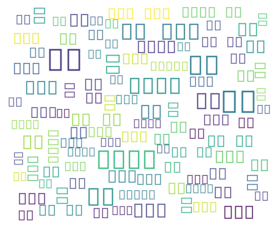

In [13]:
#font_path = '~/Library/Fonts/NotoSansCJKjp-Light.otf'
word_cloud = WordCloud(width=850, height = 700, max_font_size = 100, max_words = 100, background_color = "white").generate(' '.join(qs_new['cln_tokenized_overall_satisfaction_reason']))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [14]:
vec = TfidfVectorizer(max_df=0.50, min_df=2, ngram_range=(1,2))
X = vec.fit_transform(qs_new.cln_tokenized_overall_satisfaction_reason)

In [15]:
X_dense = X.todense()
pca = PCA(n_components = 3)
coords = pca.fit_transform(X_dense)

In [16]:
trace1 = go.Scatter3d(
    x=coords[:, 0],
    y=coords[:, 1],
    z=coords[:, 2],
    mode='markers',
    marker=dict(
        size=12,
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

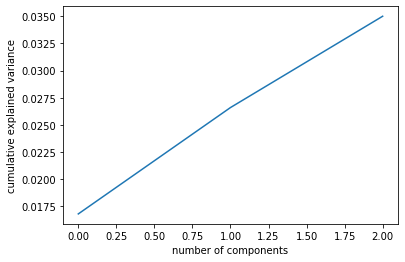

In [17]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [18]:
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df
def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [19]:
features = vec.get_feature_names()
top_feats_in_doc(X, features, 3, 10)

,features,score
0,伴う,0.805966
1,結果,0.591962
2,３つ,0.000000
3,並ぶ,0.000000
4,世代,0.000000
5,且つ,0.000000
6,与える,0.000000
7,不透明,0.000000
8,不足 開催,0.000000
9,不足 思う,0.000000


In [20]:
def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()
        D[D < min_tfidf] = 0
        tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [21]:
top_mean_feats(X, features, top_n=30)

,features,score
0,少ない,0.026560
1,人数,0.025346
2,良い,0.021312
3,参加,0.021136
4,思う,0.018411
5,楽しい,0.017126
6,人数 少ない,0.016670
7,すぎる,0.014660
8,スタッフ,0.014602
9,女性,0.012527


In [22]:
n_clusters = 8
clf = KMeans(n_clusters=n_clusters, max_iter=10000, init='k-means++', n_init=1)
labels = clf.fit_predict(X)
print(labels)

X_dense = X.todense()
coords = PCA(n_components=3).fit_transform(X_dense)

trace1 = go.Scatter3d(
    x=coords[:, 0],
    y=coords[:, 1],
    z=coords[:, 2],
    mode='markers',
    marker=dict(
        size=12,
        opacity=0.8,
        color = labels
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

[3 3 3 ... 3 3 3]


In [23]:
def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=25):
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [24]:
#print(top_feats_per_cluster(X, labels, features, min_tfidf=0.1, top_n=5))

In [25]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
X2 = small_count_vectorizer.fit_transform(qs_new.cln_tokenized_overall_satisfaction_reason)
n_topics = 5

In [26]:
lsa_model = TruncatedSVD(n_components= n_topics, n_iter =350)

In [27]:
def get_keys(topic_matrix):
    '''returns an integer list of predicted topic categories for a given topic matrix'''
    keys = []
    for i in range(topic_matrix.shape[0]):
        keys.append(topic_matrix[i].argmax())
    return keys

def keys_to_counts(keys):
    '''returns a tuple of topic categories and their accompanying magnitudes for a given list of keys'''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [28]:
lsa_topic_matrix = lsa_model.fit_transform(X2)

In [29]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)
print(lsa_keys)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 4, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0, 0, 1, 2, 4, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 4, 4, 0, 0, 0, 0, 0, 1, 1, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 4, 0, 0, 0, 4, 0, 0, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 

In [30]:
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''returns a list of n_topic strings, where each string contains the n most common 
        words in a predicted category, in order'''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('utf-8').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [31]:
top_n_words_lsa = get_top_n_words(5, lsa_keys, X2, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i), top_n_words_lsa[i])

Topic 0:  参加 人数 思う 少ない 良い
Topic 1:  思う 良い いい 交換 連絡
Topic 2:  参加 イベント 初めて コン 二度と
Topic 3:  たのしい ふつう 思う 少ない ボールペン
Topic 4:  男性 女性 男女 同上 少ない


Text(0.5, 1.0, 'LSA Topic Category Counts')

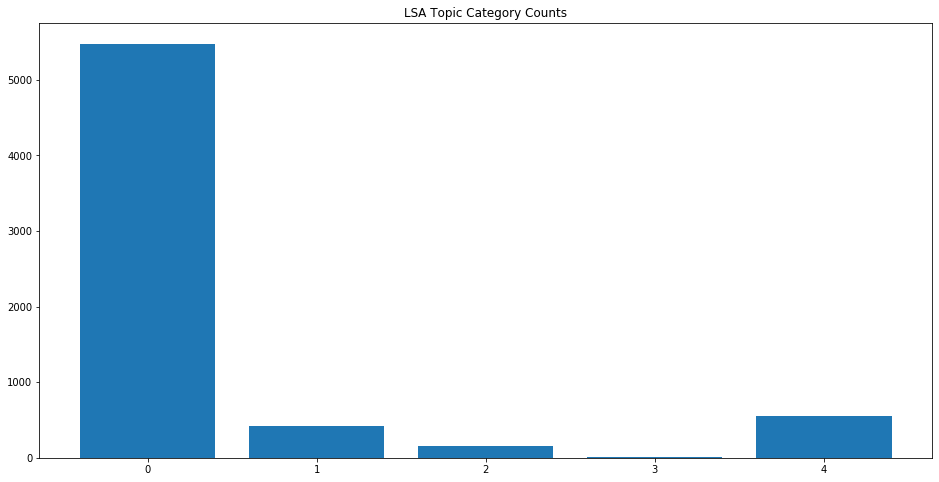

In [32]:
top_3_words = get_top_n_words(3, lsa_keys, X2, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts)
ax.set_xticks(lsa_categories)
ax.set_title('LSA Topic Category Counts')

In [33]:
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''returns a list of centroid vectors from each predicted topic category'''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [34]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=1500, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)
output_notebook()

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 6632 samples in 0.002s...
[t-SNE] Computed neighbors for 6632 samples in 0.284s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6632
[t-SNE] Computed conditional probabilities for sample 2000 / 6632
[t-SNE] Computed conditional probabilities for sample 3000 / 6632
[t-SNE] Computed conditional probabilities for sample 4000 / 6632
[t-SNE] Computed conditional probabilities for sample 5000 / 6632
[t-SNE] Computed conditional probabilities for sample 6000 / 6632
[t-SNE] Computed conditional probabilities for sample 6632 / 6632
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.738014
[t-SNE] KL divergence after 1500 iterations: 0.765836


Loading BokehJS ...

In [35]:
def rand_Hexcode(n):
    for i in range(n):
        r = lambda: random.randint(0,255)
        hcode =  '#%02X%02X%02X' % (r(),r(),r())
        yield hcode
        
colormap = np.fromiter(rand_Hexcode(n_topics), dtype='U25', count=n_topics)

In [36]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, X2, small_count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

#plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=1500, plot_height=900)
#plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

#for t in range(n_topics):
 #   label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
  #                text=top_3_words_lsa[t], text_color=colormap[t])
  #  plot.add_layout(label)
    
#show(plot)

trace1 = go.Scattergl(
        x=np.array(tsne_lsa_vectors[:,0]),
        y=np.array(tsne_lsa_vectors[:,1]),
        mode='markers',
        marker=dict(
            size=5,
            color = colormap[lsa_keys]
        )
    )
for t in range(n_topics):
    trace2 = go.Scatter(
        x=np.array(list(zip(*lsa_mean_topic_vectors))[0]),
        y=np.array(list(zip(*lsa_mean_topic_vectors))[1]),
        mode='markers+text',
        text = np.array(top_3_words_lsa[0:n_topics]),
        textfont=dict(
        family='sans serif',
        size=15,
        color=colormap[0:n_topics]
        ))
    
type(lsa_mean_topic_vectors) 
[item[0] for item in lsa_mean_topic_vectors]
data = [trace1,trace2]

layout = go.Layout(title="t-SNE Clustering of {} LSA Topics".format(n_topics),
   margin=dict(
           l=0,
           r=0,
           b=0,
           t=0
       
        )
    )
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)